# NLE Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [44]:
candidateno=251046 #this MUST be updated to your candidate number so that you get a unique data sample


In [45]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [46]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def get_train_test_data():
    
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
   
    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [47]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])


The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['"', 'you', "'", 'll', 'go', 'ape', 'over', 'tarzan', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In [48]:
stop = stopwords.words('english')

#Applying the pre-processing step of normalisation (case and number normalisation,stopword and punctuation removal)
def normalise(wordlist):
    lowered=[word.lower() for word in wordlist]
    filtered=[word for word in wordlist if word.isalpha() and word not in stop]
    return filtered

#Normalising given training_data & testing_data by converting to FreqDist
training_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in training_data]
testing_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in testing_data]

#Create FreqDists for positive and negative data.
pos_freq=FreqDist()
neg_freq=FreqDist()
for reviewDist,label in training_norm:
    if label=='pos':
        pos_freq+=reviewDist
    elif label=='neg':
        neg_freq+=reviewDist

#Finding the most frequent words as per input 'k' value
def most_freq_words(pos_freq,neg_freq,topk):
    difference=pos_freq-neg_freq
    sorteddif=difference.most_common()
    justwords= [word for (word,freq) in sorteddif[:topk]]
    return justwords


In [49]:
#1.a) list of 10 content words which are representative of the positive reviews in training data.
top_pos=most_freq_words(pos_freq,neg_freq,10)
print(top_pos)

['film', 'life', 'also', 'well', 'great', 'world', 'story', 'best', 'many', 'love']


In [50]:
##1.b) list of 10 content words which are representative of the negative reviews in training data
top_neg=most_freq_words(neg_freq,pos_freq,10)
print(top_neg)

['bad', 'movie', 'plot', 'worst', 'script', 'even', 'boring', 'get', 'stupid', 'least']


##### 1.c) First, we apply the pre-processing step of normalisations (case and number normalisation,stopword and punctuation removal etc) by defining a function called 'normalise', which will take our wordlist as argument. Here we use the predefined functions like .lower() and .isalpha() along with the stopword. We use the above processes to bring our data into a form that is more predictable and analysable.


*   Lowercasing is used to solve the sparsity issue i.e. same words with different cases will be mapped to the same lowercase form.
*   Text normalisation by removing punctuations and other unwanred data by checking if its an alphabet
* Stopword Removal are set of commonly used words in any language. Common stop words in English are “a”, “the”, “is”, “are” and etc. These common words does not add any weights while considering a sentence. By eliminating them, we can focus more on other significant words.


##### Then we further normalise given training_data & testing_data by converting to FreqDist, as it it much easier to deal with Frequency distributions rather than actual dictionary.
##### We then create Frequency distributions for the positive as well as negative data and then iterate over the normalised training data based on label being positive or negative. If its positive, we store it to pos_frequency distribution or else to neg_frequency distribution.
##### Finally, we define 'most_freq_words' function to find out the most frequent words among the training data by taking the difference of positive and negative frequencies and then use the most_common() function in 'sorteddif' to slice the top 'k' words in our list from 'justwords'
#### top_pos word list includes most frequently occurring words in positive documents
#### top_neg word list includes most frequently occurring words in negative documents
Note: k is the desired input for showing the positive as well as negative list of words.

2) 
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


In [51]:
class SimpleClassifier(ClassifierI): 

    def __init__(self, pos, neg): 
        self._pos = pos 
        self._neg = neg 

    def classify(self, doc): 
        #doc is a FreqDist
        score = 0

        for word,value in doc.items():
            if word in self._pos:
                score+=value
            if word in self._neg:
                score-=value
        
        return "neg" if score < 0 else "pos" 

    def labels(self): 
        return ("pos", "neg")


In [52]:
# Calling the word list classifier to evaluate reviews
movie_classifier= SimpleClassifier(top_pos,top_neg)
print(movie_classifier.classify(FreqDist("movie was boring".split())))
print(movie_classifier.classify(FreqDist("best film ever".split())))

neg
pos


##### 2.b)We are creating a class called 'SimpleClassifer', which will inherit all the methods of predifined class 'ClassifierI' from  nltk library.
##### For this, we first initialise our class by the standard procedure of  __init__ function, passsing the argument self, pos and neg.
##### We also create a function called 'classify' which will return value as 'neg' or 'pos' based on the score. 'classify' sets the score as 0 (for initialising) and If the word is occuring in 'pos', we increment the 'score' value or else we decrease 'score'.
We iterate the items in 'doc' to get positive and negative scores, then 'classify' returns the value 'neg' or 'pos'
##### We have used the top_pos and top_neg lists from previous question to classify an input review statement to be Positive or Negative by using simple  classifier class.

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

### Part 1 
##### Defining a Simple Classifier based on most frequent words.

In [53]:

class SimpleClassifier_mf(SimpleClassifier):     
    def __init__(self,k):
        self._k=k
    
    def train(self,training_data):
        pos_freq=FreqDist()
        neg_freq=FreqDist()
        
        for (review,label) in training_data:
            if label=='pos':
                pos_freq+=review
            else:
                neg_freq+=review
                   
        self._pos=most_freq_words(pos_freq,neg_freq,self._k)
        self._neg=most_freq_words(neg_freq,pos_freq,self._k)

###Part 2
##### Defining a class , ConfusionMatrix to calculate the Accuracy,Precision,Recall and F1 Score 

In [54]:
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("pos","neg")):
        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1
        
            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1
       
    def precision(self):
        p=0
        #print(self.TP,self.FP,self.FN,self.TN)
        p = self.TP / (self.TP + self.FP)
        return p
  
    def recall(self):
        r=0
        r=self.TP / (self.TP + self.FN)
        return r
  
    def f1(self):
        f1=0
        p = self.precision()
        r= self.recall()
        f1= (2*(p*r))/(p+r)
        return f1 


#### Part 3
###### Defining a function to evaluate the performance of our Classifiers

In [55]:
def classifier_evaluate(cls, test_data):
    acc = 0
    docs,goldstandard=zip(*test_data) # turning a list of pairs into a pair of lists
    #pass all of the docs to the classifier and get back a list of predictions
    predictions=cls.classify_many(docs)
    #zip the predictions with the goldstandard labels and compare
    for prediction,goldlabel in zip(predictions,goldstandard):
        if prediction==goldlabel:
            acc+=1
    return acc / (len(test_data))

training,testing=get_train_test_data()

threshold=[1,10,50,100,200,400,600, 700]
#threshold=range(100,4000,100)
plt_acc=[]
plt_prec=[]
plt_recl=[]
plt_f1=[]
x_count=[]

for i in threshold:
  classifier=SimpleClassifier_mf(i)
  classifier.train(training_norm)
  docs,labels=zip(*testing_norm)
  senti_cm=ConfusionMatrix(classifier.classify_many(docs),labels)
  accuracy=classifier_evaluate(classifier,testing_norm)
  plt_acc.append(accuracy)
  print("The accuracy of classifier is {}".format(plt_acc))
  plt_prec.append(senti_cm.precision())
  print("The precision of World List classifier is {}".format(plt_prec))
  plt_recl.append(senti_cm.recall())
  print("The recall of World List classifier is {}".format(plt_recl))
  plt_f1.append(senti_cm.f1())
  print("The f1 of World List classifier is {}".format(plt_f1))
  x_count.append(i)  

The accuracy of classifier is [0.5483333333333333]
The precision of World List classifier is [0.5263157894736842]
The recall of World List classifier is [0.9666666666666667]
The f1 of World List classifier is [0.6815511163337251]
The accuracy of classifier is [0.5483333333333333, 0.6283333333333333]
The precision of World List classifier is [0.5263157894736842, 0.5918854415274463]
The recall of World List classifier is [0.9666666666666667, 0.8266666666666667]
The f1 of World List classifier is [0.6815511163337251, 0.6898470097357441]
The accuracy of classifier is [0.5483333333333333, 0.6283333333333333, 0.6233333333333333]
The precision of World List classifier is [0.5263157894736842, 0.5918854415274463, 0.5734126984126984]
The recall of World List classifier is [0.9666666666666667, 0.8266666666666667, 0.9633333333333334]
The f1 of World List classifier is [0.6815511163337251, 0.6898470097357441, 0.7189054726368159]
The accuracy of classifier is [0.5483333333333333, 0.6283333333333333,

In [20]:
import numpy as np

print("The Accuracy of the Wordlist classifier is : {} %".format(np.mean(plt_acc)*100))
print("The Precision of the Wordlist classifier is : {} %".format(np.mean(plt_prec)*100))
print("The Recall of the Wordlist classifier is : {} %".format(np.mean(plt_recl)*100))
print("The F1 Score of the Wordlist classifier is : {} %".format(np.mean(plt_f1)*100))

The Accuracy of the Wordlist classifier is : 61.958333333333336 %
The Precision of the Wordlist classifier is : 57.373471601378945 %
The Recall of the Wordlist classifier is : 94.41666666666667 %
The F1 Score of the Wordlist classifier is : 71.28335751804883 %


##### 3.a) In this section, we are dividing the solution into 3 parts for better understanding :
1. Defining a class called 'SimpleClassifier_mf'
2. Defining a class called 'ConfusionMatrix' to find the precision,F1 score and recall
3. Defining a function called 'classifier_evaluate' to evaluate the performance of the above class.

We calculated the Accuracy of the Wordlist classifier as 0.618
We calculated the Precision of the Wordlist classifier as 0.569
We calculated Recall of the Wordlist classifier as 0.976
We calculated F1 Score of the Wordlist classifier as 0.719

##### The above values of Accuracy,Precision,Recall and F1 score are calculated based on mathematical formulas, which are respectively given below :

1.   Accuracy is defined as the proportion of items in the test set that are classified correctly,  = (TP + TN) /N 
2.   Precision is the proportion of positive predictions that are correct, = TP / (TP + FP) 
3. Recall is the proportion of actually postitive documents that are predicted correctly, = TP / (TP + FN)
4. F1 Score We combine precision (P) and recall (R) scores using the F1-score, = 2PR / (P+R)




* i. First, we call the earlier class 'SimpleClassifier' to inherit all its methods and initialise our new class passing the 'k' value. 
then we use the function 'most_freq_words' for passing the initial values to 'pos' as well as 'neg', which will be passed into the original 'SimpleClassifier' (in the 'classify' function)

* ii. Secondly, we initialise the class 'ConfusionMatrix' with 'predictions','goldstandard' and 'classes' ('pos' & 'neg').
We set True Positive (TP), False Positive(FP), False Negative(FN) and True Negative(TN) as 0.
We then iterate over 'predictions' and 'goldstandard'. If the prediction and the gold standard turn out to be 'pos', we increment TP by 1 or else increment FN.
Next, we check if our predictions is equal to 'pos'. If true, increment FP by 1.
If none of the above condition hold good, we increment TN value by 1.
Then we define the functions 'precision', 'recall' and 'f1' as per the mathematical formula.
* iii. Lastly, we define the 'classifer_evaluate' taking arguments 'cls' and 'test_data'.
We first turn our list of pairs into a pair of list and then pass all the 'docs' to the classifier 'cls' and store it to 'predictions'.
Then we zip the predictions with the goldstandard labels and compare.
Afterwards, we call the 'get_train_test_data' function, which splits out the training and testing dataset.
We use the 'threshold' list as 1,10,50,100,200,400,600,700.The following empty lists are used for plotting the graphs for accuracy,precision,recall and f1 score respectively :plt_acc,plt_prec,plt_recl,plt_f1.
x1 is used to keep track of the count of iterations perfomed.

We call the SimpleClassifier_mf class from 'classifier' and then use the method 'train' on our normalised training data.We then call the ConfusionMatrix from 'senti_cm' and calculate the accuracy,precision,recall and f1 scores of our classifier.


3.b) It is not always best to evaluate the classifier performance in terms of accuracy. To demonstrate the same,we consider an unbalanced class where the accuracy is very high (say 90%). While creating a model to perform classification, 90% data points are in class A and remaining 10% are in class B. 
We have a model that predicts class A which is  90% of the samples. Hence, the accuracy of our model is 90%. if we need try to predict class B, the accuracy will be only 10%, which means that our model will most likely fail while predicting class B. This is a classic example of biased classifier.


*   To demonstrate the above, lets consider a simple real life example of a grocery shop selling banana.Each kg of banana is sold for 5 dollar.Every customer entering the shop may or may not but banana.For some frequent customers,we decided to give $1 discount even if the profit is reduced.The margin becomes just 1 dollar, but we are positive that those customers will always buy.
Lets analyses the customer behaviour with features such as "sniffs the banana", "wearing gym dress"... and classify them into "wants to buy at 5 dollars" (positive) and "wants to buy only at 4 dollar" (negative).

*   If the classifier makes no mistake, then we get the maximum possible revenue and If it's not perfect, then:
••	•for every false positive you loose 1 dollar because the customer leaves and you didn't try to make a successful discount
••	•for every false negative you loose 1 dollar because you make a useless discount
Then the accuracy of your classifier is exactly how close you are to the maximum revenue. 








4) 
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results. 

[12.5\%]

In [21]:

classifier_NB = nltk.NaiveBayesClassifier.train(training_norm)
print("Naive Bayes Classifier accuracy percent:",(nltk.classify.accuracy(classifier_NB, testing_norm))*100)
print("The Accuracy of our Word list classifier is {}".format(np.mean(plt_acc)*100))
classifier_NB.show_most_informative_features(10)

Naive Bayes Classifier accuracy percent: 69.83333333333334
The Accuracy of our Word list classifier is 61.958333333333336
Most Informative Features
                  stupid = 2                 neg : pos    =     15.7 : 1.0
              commanding = 1                 pos : neg    =     15.7 : 1.0
               stupidity = 1                 neg : pos    =     15.0 : 1.0
                  boring = 2                 neg : pos    =     13.7 : 1.0
                   blend = 1                 pos : neg    =     11.7 : 1.0
               wonderful = 2                 pos : neg    =     11.7 : 1.0
                ordinary = 1                 pos : neg    =      9.8 : 1.0
             outstanding = 1                 pos : neg    =      9.7 : 1.0
                    lean = 1                 pos : neg    =      9.7 : 1.0
              astounding = 1                 pos : neg    =      9.7 : 1.0


4.a) We are using the 'NaiveBayesClassifier' defined in nltk library.
*   Bayes theorem is used to find the conditional probabilities of occurrence of two events based on the probability of occurrence of each individual event. Naive Bayes used the same philosophy to give the probability of different class and then label it with the class having maximum probability.Main idea here is to count how many times each attribute co-occurs with each class.


4.b) Accuracy of the our word list classifier is around 62% by taking the averages and the accuracy of the Naive Bayes classifier is about 70%, which is obtained from 'NaiveBayesClassifier' defined in nltk library.



##### Advantages of Using Naive Bayes Classifier
Main advantage is its simplicity and if the conditional Independence holds good,the results would be excellent. Conditional probabilities are fast and easy to implement.Here, we are giving weights to certain words and based on the occurance of that word, we classify our dataset as Positive or Negative.


##### Disadvantages of Using Naive Bayes Classifier
Main disadvantage is that in most situations, the feature show some form of dependency and conditional Independence does not hold good. Also, we might end up with zero class probabilities sometimes when the words in the test data for a particular class are not present in the training data.

##### Advantages of using our simple wordlist classifier is that, we do not need to worry about the events being mutally exclusive like as in the case of Naive Bayes.We also dont face an issue like Zero probability as in the case of Naive Bayes.

##### Disadvantage of using the simple wordlist classifier is that, we are not able to get a higher accuracy model. Here,we are considering the same weight for evey words, i.e. unity. Hence, the predictions are purely based on the score being positive or negative.


5) 
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions. 

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


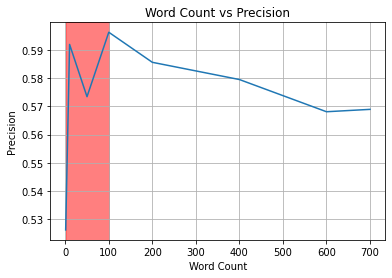

In [41]:
# Plotting the Graph for Word Count vs Precision
import matplotlib.pyplot as plt
plt.xlabel("Word Count")
plt.ylabel("Precision")
plt.title("Word Count vs Precision")
plt.grid(True)
plt.plot(x_count,plt_prec)
plt.axvspan(2, 100, color='red', alpha=0.5)
plt.show()


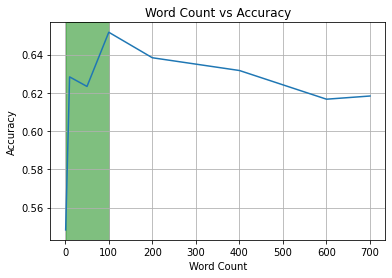

In [39]:
# Plotting the Graph for Word Count vs Accuracy
plt.xlabel("Word Count")
plt.ylabel("Accuracy")
plt.title("Word Count vs Accuracy")
plt.plot(x_count,plt_acc)
plt.axvspan(2, 100, color='green', alpha=0.5)
plt.grid(True)
plt.show()


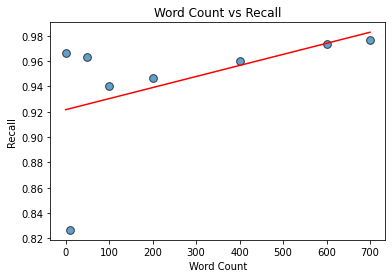

In [40]:
fig, ax = plt.subplots()
ax.scatter(x_count, plt_recl, s=60, alpha=0.7, edgecolors="k")
b, a = np.polyfit(x_count, plt_recl, deg=1)
xseq = np.linspace(0, 700, num=10)
ax.plot(xseq, a + b * xseq, color="r", lw=1.5);

plt.xlabel("Word Count")
plt.ylabel("Recall")
plt.title("Word Count vs Recall")
plt.show()

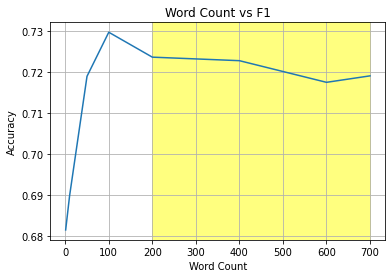

In [38]:
# Plotting the Graph for Word Count vs F1 Score
plt.xlabel("Word Count")
plt.ylabel("Accuracy")
plt.title("Word Count vs F1")
plt.plot(x_count,plt_f1)
plt.axvspan(200, 700, color='yellow', alpha=0.5)
plt.grid(True)
plt.show()

##### 5.a) For this experiment, we have considered a maximum wordcount of 700  . The threshold is taken as 1,10,50,100,200,400,600, 700.Below we observe 4 graphs, which provide us the required outcome , i.e. relation between wordcounts, precision,accuracy, recall, F1 score, etc.
We have iterated our SimpleClassifier_mf defined in Q3 as per the above threshold values for visualising our results.

1.   "Word Count vs Precision".
we observe from the graph that as amount of training data increase, the precision of the classifer increases till a peak value (sample size around 100) and then plummets at a linear place to finally flatten. The most fluctuations happen in the red highlighted region, presumably caused by a certain word or words being in or out of the list at that particular point. 
2.   "Word Count vs Accuracy".
we observe from the graph that as word count increase, the accuracy of the classifer increases till a peak value  and then plummets. This graph is identical to the earlier graph obtained while plotting "Word Count vs Precision".
3. "Word Count vs Recall".
We use a scatter plot for this experiment and it is evident from the graph that the relation is mostly linear.The regression line can also be seen in RED color.
This means that our model is not over fitting, i.e. most of the pos and neg documents are being predicted correctly.

4. "Word Count vs F1 Score".
we observe from the graph that as word count increase, the precision of the classifer increases till a peak value i.e. 100. Since this parameter is related to values of precision and recall, it follows the same trend.

From the above trends, we realise that as amount of training data increase, all the parameters increase to hit a peak and then plummets due to overfitting.

#### 5.b) I would recommend Naive Bayes Classifier

I would recommend Naive Bayes Classifier for similar kind of works as our classifier evaluates a certain phrase/word being positive or negative. Since this classification is binary, the conditional independence assumption would probably hold good.
As established in the earlier discussion, the Naive bayes classifier is working based on weights of words rather than score. Hence, this would yield a more accurate model for classification.
  Another reason to consider this one is the redundancy. This method is quite famous and has been tried and tested by many for various applications. This would be by far the most versatile method for delivering the optimum result.

In [56]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 437
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

import io
from nbformat import current

filepath="/content/drive/My Drive/Colab Notebooks/NLassignment2021.ipynb"
#filepath="NLassignment2021.ipynb"
question_count=437

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:#
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Mounted at /content/drive
Submission length is 1906
